## Modelling Patient Responses

First the usable patient responses must be imported.

In [2]:
from bids import BIDSLayout
import json
import pandas as pd
import os
from scipy.optimize import minimize
from tqdm import tqdm

from Carl_load_responses import *
from scipy.signal import welch, detrend

participants_df = pd.read_csv('openpain.org/subacute_longitudinal_study/participants.tsv', sep='\t')
chronic_df = participants_df.loc[participants_df["group"] == "chronic"]

This code is from `06_analysing_chronic_patients` by Maeghal Jain

In [3]:
def get_number_of_sessions_for_each_subject(chronic_patients):
    """
    Returns a dict that contains the number of sessions a participant was present for.
    Here the key = participant_id, and the value = count os sessions.
    """
    participant_and_sessions = {}
    parent_dir = "openpain.org/subacute_longitudinal_study/"
    for folder in os.listdir(parent_dir):
        if folder.startswith("sub"):
            sub_id = int(folder[4:])
            if sub_id in chronic_patients:
                subject_dir = os.path.join(parent_dir, folder)
                count = 0
                for subject_folder in os.listdir(subject_dir):
                    if subject_folder.startswith("ses"):
                        count += 1
                participant_and_sessions[subject_dir[-3:]] = count
    
    participant_and_sessions = dict(sorted(participant_and_sessions.items(), key=lambda kv: kv[0]))
    return participant_and_sessions

In [4]:
get_number_of_sessions_for_each_subject(chronic_df['participant_id'])

{'096': 4,
 '097': 4,
 '098': 4,
 '099': 4,
 '100': 4,
 '101': 4,
 '102': 4,
 '103': 4,
 '104': 4,
 '105': 4,
 '106': 4,
 '107': 4,
 '108': 4,
 '109': 4,
 '110': 4,
 '111': 4,
 '112': 4,
 '113': 4,
 '114': 4,
 '115': 4,
 '116': 4,
 '117': 4,
 '118': 4,
 '119': 4,
 '120': 4,
 '121': 4}

In order to make progress, the kalman filter for the responses is now written from the paper (Onysk et al.).

In [5]:
import Carl_models.VKF as vkf
import Carl_models.RL as rl
from Carl_models.Synthetic import *
import scipy.optimize as spop
from scipy.special import expit as sigmoid

## Running the KF, VKf, RL filters for a single subject

Here the Kalman filter, volative kalman filter and a basic reinforcement learning model was run through the patient pain ratings, to estimate the value of the underlying latent variable, the true relative value of the patient pain.

In [6]:
norm = lambda x : (x-x.mean())/x.std()

def fit_and_run_VKF(data):
    outcomes = np.reshape(data, (len(data), 1))

    #fit VKF model
    x0 = [0.1, 0.1, 0.2]
    xopt, fopt, func_calls, grad_calls, warnflag, allvecs = spop.fmin_cg(
        f = vkf.vkf_min,
        x0 = x0,
        args = (data,),
        maxiter=1000,
        full_output = True,
        retall = True
    )
    finals = np.exp(xopt)

    # run VKF model
    model = vkf.VKF(lambd=finals[0], v0=finals[1], sigma2=finals[2])
    signals = model.run_on_outcomes(outcomes)
    signals['data'] = data

    return signals, model.loglikelihood()

def fit_and_run_RL(data):
    # reshape and fit model
    outcomes = np.reshape(data, (len(data), 1))

    #train RL model
    # set starting point for RL optimisation
    params = np.log([0.1, 1, 1])

    # run RL optimisation and store
    xopt, fopt, func_calls, grad_calls, warnflag, allvecs = spop.fmin_cg(
        f = rl.rl_min,
        x0 = params,
        args = (data,),
        maxiter=1000,
        full_output = True,
        retall = True
    )
    finals = np.exp(xopt)

    # fit RL model
    rl_model = rl.ReinforcementLearningModel(sigmoid(finals[0]), finals[1], finals[2])
    rl_model.run_on_data(data)

    #rl_model.plot_traces()
    
    return rl_model.expectations, rl_model.errors, rl_model.loglikelihood()

In [7]:
sub = "sub-100"
data = load_single_subject_response(subject = sub, visit= 1, run= 1, plot = 0, task_type = 'sp', downsample = False)
BURN_IN_NUM = 4*36
clippedData = data[BURN_IN_NUM:]

RLexpectations, errors, ll_RL = fit_and_run_RL(clippedData)

loading the data of: 
      group     race gender  age origin
99  chronic  1 and 6      M   41      4
len of responses:  8784
         Current function value: 2973.094610
         Iterations: 5
         Function evaluations: 132
         Gradient evaluations: 30


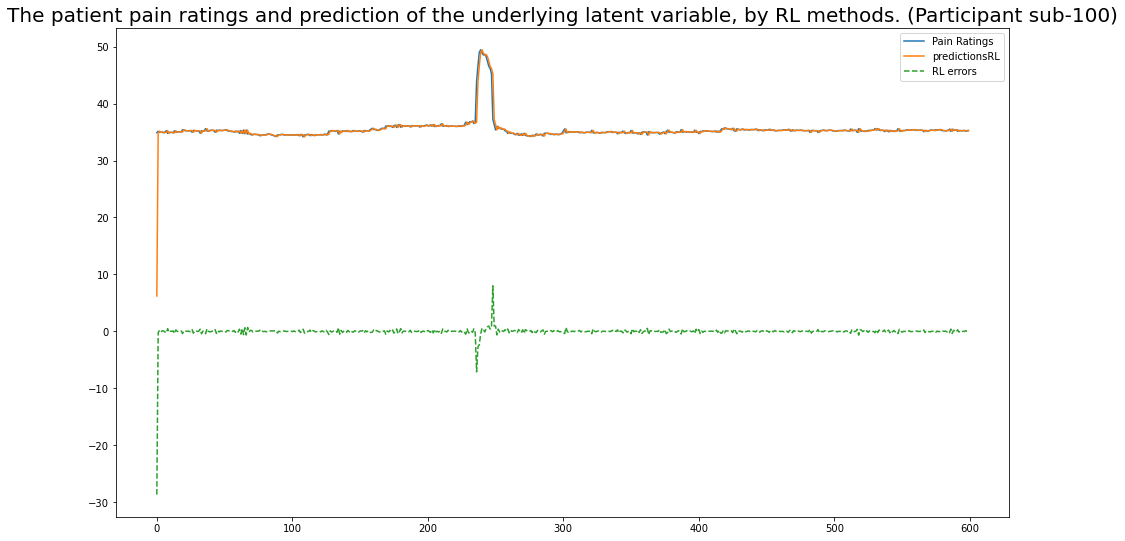

In [8]:
#plot the fits
fig = plt.figure(figsize=(16,9))
END_DISPLAY = 600

plt.plot(clippedData[:END_DISPLAY],label="Pain Ratings")
plt.plot(RLexpectations[:END_DISPLAY],label="predictionsRL")
plt.plot(errors[:END_DISPLAY],label="RL errors",linestyle='dashed')

_ = plt.title(f"The patient pain ratings and prediction of the underlying latent variable, by RL methods. (Participant {sub})",fontsize = 20)
plt.legend()

In [9]:
print(ll_RL)

-2973.094610178312


## THE VKF

In [10]:
sub = "sub-100"
data = load_single_subject_response(subject = sub, visit= 1, run= 1, plot = 0, task_type = 'sp', downsample = False)
BURN_IN_NUM = 4*36
clippedData = data[BURN_IN_NUM:]

signalsVKF, ll_VKF = fit_and_run_VKF(clippedData)

loading the data of: 
      group     race gender  age origin
99  chronic  1 and 6      M   41      4
len of responses:  8784


KeyboardInterrupt: 

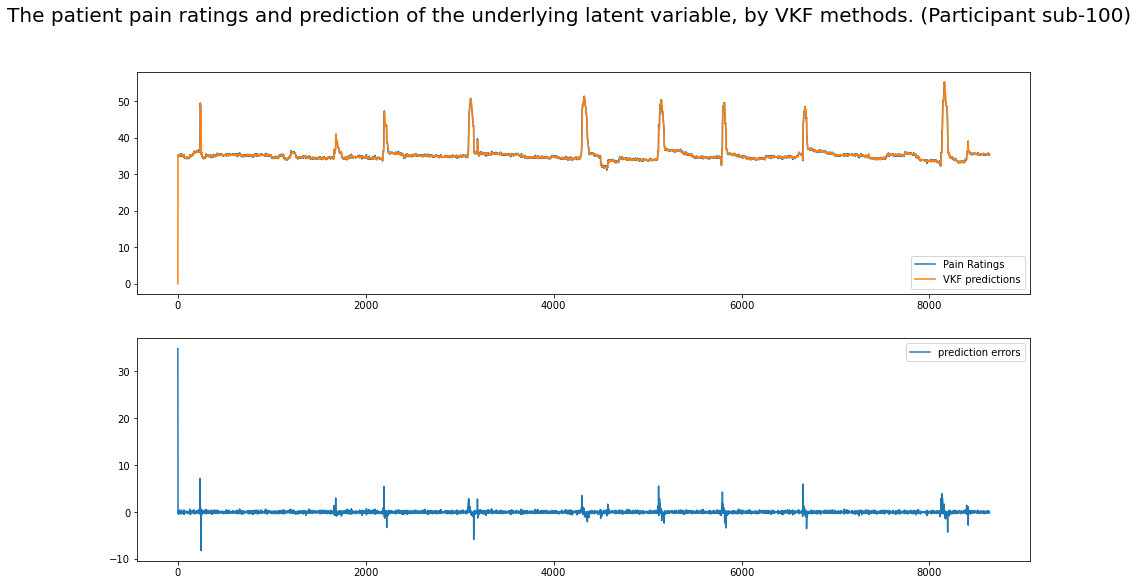

In [ ]:
#plot the fits
fig, ax = plt.subplots(2,1,figsize=(16,9))
END_DISPLAY = 8784
ax[0].plot(signalsVKF['data'][:END_DISPLAY], label="Pain Ratings")
ax[0].plot(signalsVKF['predictions'][:END_DISPLAY], label="VKF predictions")
ax[0].legend()
plt.suptitle(f"The patient pain ratings and prediction of the underlying latent variable, by VKF methods. (Participant {sub})",fontsize = 20)

ax[1].plot(signalsVKF['prediction_error'][:END_DISPLAY], label="prediction errors")
plt.legend()